## Project Submission

Please fill out:
* Student name: Daniel Bradley and Monica Haderthauer
* Student pace: full time
* Scheduled project review date/time: 03/31/2022
* Instructor name: Praveen Gowtham
* Blog post URL: https://github.com/DanlBradley/Phase2Project


In [221]:
# Your code here - remember to use markdown cells for comments as well!
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

%matplotlib inline

## Initial inspection and cleaning
- Clean up DataFrame, drop NaN entries if there is sufficient data, and look for NaN entries that go under a placeholder name
- Split DataFrame into numerics and categorical variables
- Basic feature engineering such as 'price / sqfoot' column and 'renovated vs. not renovated' column

In [238]:
#Create housing dataframe
df = pd.read_csv('data/kc_house_data.csv')
#Clean up NaNs
df['sqft_basement'] = df['sqft_basement'].replace('?',np.nan)
df.drop(columns = 'sqft_lot15')
df = df.dropna()


#Convert date string to datetime
df['date'] = pd.to_datetime(df['date'])


#Convert sqft_basement to a float
df['sqft_basement'] = df['sqft_basement'].apply(lambda x: float(x))


#Add categorical column "renovated" vs "not renovated"
df['renovated_status'] = df['yr_renovated'].apply(lambda x: 'NO' if x == 0 else 'YES')


#Add a price / sqfoot column
df['price_per_sqfoot'] = df['price'] / df['sqft_above']

In [239]:
#Create dataframe for just numerics
df_numerics = df.select_dtypes(include = np.number, exclude = object)

#Select a target metric to compare other columns to
target_metric = 'price_per_sqfoot'

In [241]:
#Create a categorical dataframe
df_cat = df[['waterfront','view','condition','grade','renovated_status']]

In [242]:
#Make a multiple linear regression model to check parameters performance on predicting target metric (chosen above in cell 3)
y = df_numerics[target_metric]
x = sm.add_constant(df_numerics.drop(columns=[target_metric,'id','yr_renovated','zipcode','sqft_lot15']))
model = sm.OLS(y,x).fit()

/Users/danielbradley/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


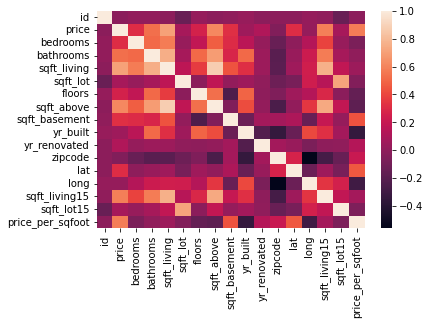

In [243]:
import seaborn as sns

#Correlation matrix
Var_Corr = df_numerics.corr()
# plot the heatmap and annotation on it
sns.heatmap(Var_Corr, xticklabels=Var_Corr.columns, yticklabels=Var_Corr.columns, annot=False);

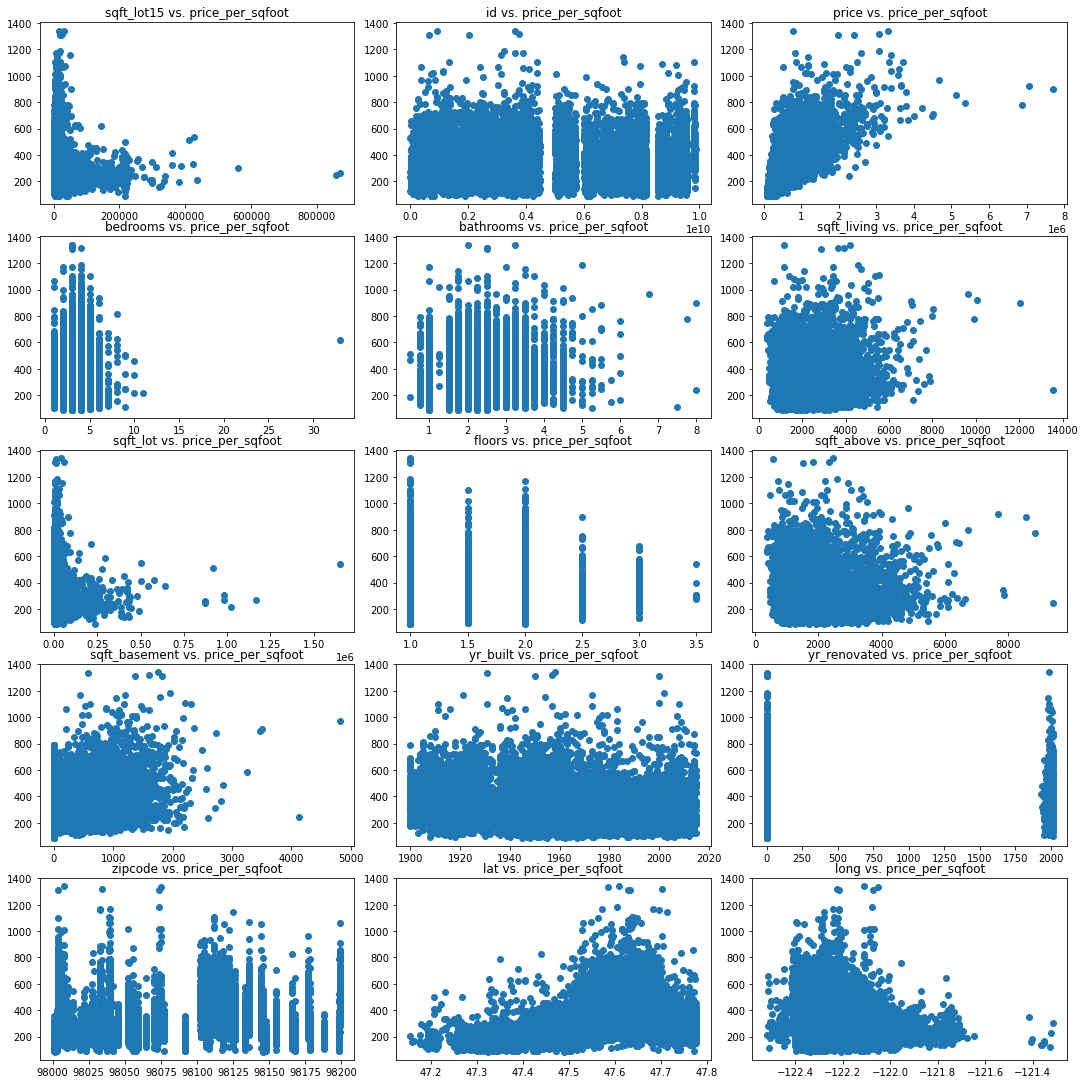

In [244]:
fig, axs = plt.subplots(5,3)


fig.set_figheight(15)
fig.set_figwidth(15)
plt.tight_layout()
independants = df_numerics.drop(columns=target_metric)
dependant = df_numerics[target_metric]
column_num = 0

for i in range(5):
    for j in range(3):
        axs[i,j].scatter(independants.iloc[:,(column_num-1)],dependant)
        axs[i,j].set_title('{} vs. {}'.format(independants.columns[column_num-1], target_metric))
        column_num += 1

In [247]:
import folium
df_renovated = df_numerics.loc[df_numerics['yr_renovated'] != 0]
lat = df_renovated['lat']
long = df_renovated['long']

#Create a map of the area
base_map = folium.Map([lat.mean(), long.mean()], zoom_start=13)

for lat1,long1 in zip(lat,long):
     popup_text = 'Lat: {} \n Long: {}'.format(lat1,long1)
     popup = folium.Popup(popup_text, parse_html=True)
     marker = folium.Marker(location=[lat1, long1], popup = popup)
     marker.add_to(base_map)
     
base_map


In [31]:
df_numerics.loc[df_numerics['lat'] == 47.6036]

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price_per_sqfoot
12830,9826701345,498000.0,3,2.5,1620,2640,2.0,1620,1900,1993.0,98122,47.6036,-122.305,1370,3840,307.407407


## Combining seattle AirBNB data with seattle housing data 
- Determine a predictive model for homes doing well in airbnb vs. the housing data
- Then make inferences about what to look for in a home when buying as an AirBNB investment

In [284]:
bnb_listings = pd.read_csv('data/listings.csv')
bnb_listings['longitude'] = round(bnb_listings['longitude'],3)
bnb_listings['long'] = round(bnb_listings['longitude'],3)
bnb_listings['latitude'] = round(bnb_listings['latitude'],3)
bnb_listings['lat'] = round(bnb_listings['latitude'],3)

In [285]:
merged = df.merge(bnb_listings, how = 'inner', on = ['long','lat'])

In [286]:
lat = merged['lat']
long = merged['long']

#Create a map of the area
base_map = folium.Map([lat.mean(), long.mean()], zoom_start=12)

for lat1,long1 in zip(lat,long):
     popup_text = 'Lat: {} \n Long: {}'.format(lat1,long1)
     popup = folium.Popup(popup_text, parse_html=True)
     marker = folium.Marker(location=[lat1, long1], popup = popup)
     marker.add_to(base_map)
     
base_map;

In [138]:
print(list(merged.columns))

['id_x', 'date', 'price_x', 'bedrooms_x', 'bathrooms_x', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode_x', 'lat', 'long', 'sqft_living15', 'sqft_lot15', 'id_y', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary', 'space', 'description', 'experiences_offered', 'neighborhood_overview', 'notes', 'transit', 'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_since', 'host_location', 'host_about', 'host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 'host_listings_count', 'host_total_listings_count', 'host_verifications', 'host_has_profile_pic', 'host_identity_verified', 'street', 'neighbourhood', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'city', 'state', 'zipcode_y', 'market', 'smart_location', 'country_code', 

In [299]:
merged_numerics = merged.select_dtypes(include = np.number, exclude = object)
merged_numerics = merged_numerics.drop(columns = ['square_feet','license'])
merged_numerics = merged_numerics.dropna()
merged_numerics.shape

(67, 45)

In [304]:
#Make a multiple linear regression model to check parameters performance on predicting target metric (chosen above in cell 3)
bnb_metric = 'review_scores_value'
y = merged_numerics[bnb_metric]
x = sm.add_constant(merged_numerics.drop(columns=[bnb_metric]))
model = sm.OLS(y,x).fit()
model.summary()

/Users/danielbradley/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     review_scores_value   R-squared:                       0.799
Model:                             OLS   Adj. R-squared:                  0.571
Method:                  Least Squares   F-statistic:                     3.514
Date:                 Sat, 26 Mar 2022   Prob (F-statistic):           0.000311
Time:                         16:27:23   Log-Likelihood:                 3.3884
No. Observations:                   67   AIC:                             65.22
Df Residuals:                       31   BIC:                             144.6
Df Model:                           35                                         
Covariance Type:             nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
id_x                           -9.212e-12   2.24e-11     -0.410      0.684    -5.5e-11    3.66e-11
price_x                         2.026e-07   7.28e-07      0.278      0.783   -1.28e-06    1.69e-06
bedrooms_x                         0.0408      0.069      0.595      0.556      -0.099       0.181
bathrooms_x                        0.0052      0.146      0.035      0.972      -0.293       0.303
sqft_living                       -0.0089      0.015     -0.598      0.554      -0.039       0.021
sqft_lot                        5.441e-05   2.55e-05      2.132      0.041    2.35e-06       0.000
floors                            -0.1392      0.195     -0.712      0.482      -0.538       0.259
sqft_above                         0.0084      0.015      0.569      0.574      -0.022       0.039
sqft_basement                      0.0091      0.015      0.614      0.544      -0.021       0.039
yr_built                           0.0046      0.003      1.601      0.120      -0.001       0.010
yr_renovated                    8.075e-06      0.000      0.064      0.949      -0.000       0.000
zipcode_x                         -0.0068      0.008     -0.802      0.429      -0.024       0.010
lat                               -0.5092      1.109     -0.459      0.649      -2.771       1.753
long                               1.0748      1.091      0.985      0.332      -1.151       3.300
sqft_living15                   2.588e-05      0.000      0.149      0.883      -0.000       0.000
sqft_lot15                      2.971e-05   4.76e-05      0.625      0.537   -6.73e-05       0.000
price_per_sqfoot                  -0.0013      0.001     -1.057      0.299      -0.004       0.001
id_y                            6.751e-09   3.44e-08      0.196      0.846   -6.34e-08    7.69e-08
scrape_id                       4.761e-11   4.32e-11      1.101      0.279   -4.06e-11    1.36e-10
host_id                         1.215e-09   5.87e-09      0.207      0.837   -1.08e-08    1.32e-08
host_listings_count               -0.0296      0.072     -0.413      0.682      -0.176       0.117
host_total_listings_count         -0.0296      0.072     -0.413      0.682      -0.176       0.117
latitude                          -0.5092      1.109     -0.459      0.649      -2.771       1.753
longitude                          1.0748      1.091      0.985      0.332      -1.151       3.300
accommodates                      -0.0958      0.086     -1.120      0.271      -0.270       0.079
bathrooms_y                       -0.0377      0.115     -0.329      0.744      -0.271       0.196
bedrooms_y                         0.1218      0.135      0.905      0.373      -0.153       0.396
beds                              -0.0582      0.122     -0.478      0.636      -0.306       0.190
gue

In [139]:
#Clean up this gigantic DataFrame by dropping irrelevant columns
#merged_numerics.drop(columns = [])

,id_x,date,price_x,bedrooms_x,bathrooms_x,sqft_living,sqft_lot,floors,waterfront,view,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,1175000570,2015-03-12,530000.0,5,2.00,1810,4850,1.5,NO,NONE,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,1,4.43
1,1175000570,2015-03-12,530000.0,5,2.00,1810,4850,1.5,NO,NONE,...,9.0,f,NaN,WASHINGTON,f,moderate,f,f,1,3.75
2,1324300398,2015-04-09,560000.0,3,1.00,1110,5000,1.5,NO,NONE,...,10.0,f,NaN,WASHINGTON,t,moderate,t,t,3,3.43
3,7132300695,2015-04-21,435000.0,3,1.50,1300,3348,1.5,NO,NONE,...,10.0,f,NaN,WASHINGTON,t,moderate,f,f,1,8.55
4,5249800729,2015-03-30,680000.0,6,3.50,3000,6320,2.0,NO,AVERAGE,...,9.0,f,NaN,WASHINGTON,f,strict,f,f,1,1.35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,6056100114,2014-08-25,477000.0,3,2.50,2100,5060,2.0,NO,NONE,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,1.80
78,6056100114,2014-08-25,477000.0,3,2.50,2100,5060,2.0,NO,NONE,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,1.61
79,8673400020,2015-03-11,590000.0,3,3.00,1740,1100,3.0,NO,NONE,...,NaN,f,NaN,WASHINGTON,f,flexible,f,f,1,NaN
80,6140100028,2015-05-01,370000.0,3,1.75,1496,1423,2.0,NO,NONE,...,10.0,f,NaN,WASHINGTON,f,flexible,f,f,3,0.21


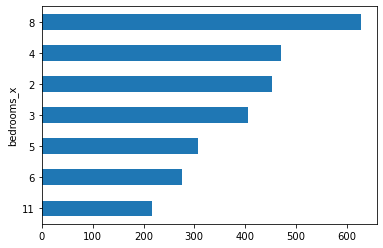

In [305]:
#This cell is just to take a look at some of the categorical columns vs. sales
merged.groupby('bedrooms_x')[target_metric].mean().sort_values().plot.barh();